In [6]:
# !pip install -q torchtext==0.18.0
# !pip install -q transformers  diffusers  pandas numpy
# !pip install -Uq datasets huggingface_hub fsspec

In [7]:
# from google.colab import drive
# from google.colab import userdata
# from huggingface_hub import login
import os
import re
import collections
import datetime
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from sklearn.metrics import confusion_matrix, classification_report
import datasets
import tqdm
import gradio as gr

In [8]:
# #credintials
# hf_token = userdata.get('HF_TOKEN')
# login(hf_token, add_to_git_credential=True)
# drive.mount('/content/drive')

In [9]:
#hyper_parameters
seed = 42
embedding_dim = 100
batch_size = 512
n_epochs = 15
model_name = "bert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
classes = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

Using device: cuda


In [10]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(seed)

In [11]:
def load_and_prepare_data(seed=seed):
    train_data, test_data = datasets.load_dataset("dair-ai/emotion", split=["train", "test"])
    train_validation = train_data.train_test_split(test_size=0.25, seed=seed)
    train_data = train_validation['train']
    validation_data = train_validation['test']
    return train_data, validation_data, test_data

train_data, validation_data, test_data = load_and_prepare_data()

In [12]:
#tokenization
def tokenize_data(train_data, validation_data, test_data,autotokenizer):

  def _tokenize(batch):
    return autotokenizer(batch["text"], padding="max_length", truncation=True, max_length=embedding_dim)

  train_data_numericalized = train_data.map(_tokenize, batched=True, batch_size=len(train_data))
  validation_data_numericalized = validation_data.map(_tokenize, batched=True, batch_size=len(validation_data))
  test_data_numericalized = test_data.map(_tokenize, batched=True, batch_size=len(test_data))

  for ds in [train_data_numericalized, validation_data_numericalized, test_data_numericalized]:
    ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])

  return train_data_numericalized, validation_data_numericalized, test_data_numericalized

autotokenizer = AutoTokenizer.from_pretrained(model_name)
train_data_numericalized, validation_data_numericalized, test_data_numericalized = tokenize_data(train_data, validation_data, test_data, autotokenizer)

Map: 100%|██████████| 2000/2000 [00:00<00:00, 16261.94 examples/s]


In [13]:
def create_data_loaders(train_data_numericalized, validation_data_numericalized, test_data_numericalized, batch_size):
    train_data_loader = DataLoader(train_data_numericalized, batch_size, shuffle=True)
    valid_data_loader = DataLoader(validation_data_numericalized, batch_size, shuffle=True)
    test_data_loader = DataLoader(test_data_numericalized, batch_size, shuffle=True)
    return train_data_loader, valid_data_loader, test_data_loader

train_data_loader, valid_data_loader, test_data_loader = create_data_loaders(
    train_data_numericalized, validation_data_numericalized, test_data_numericalized, batch_size
)

In [14]:
def count_parameters(my_model):
    return sum(p.numel() for p in my_model.parameters() if p.requires_grad)

In [15]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [16]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses, epoch_accs = [], []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["input_ids"].to(device)
        att = batch["attention_mask"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids, att)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [17]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses, epoch_accs = [], []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["input_ids"].to(device)
            att = batch["attention_mask"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids, att)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [18]:
def print_classification_summary(prediction, label, class_dict):
    predicted_classes = prediction.argmax(dim=-1).cpu().numpy()
    true_labels = label.cpu().numpy()
    target_names = [class_dict[i] for i in range(len(class_dict))]
    report = classification_report(true_labels, predicted_classes, target_names=target_names, digits=3)
    print("\nClassification Summary:\n")
    print(report)

In [19]:
def predict_sentiment(text, model, tokenizer, device, embedding_dim, classes):
    obj = tokenizer(text, padding="max_length", truncation=True, max_length=embedding_dim)
    ids = obj['input_ids']
    atts = obj['attention_mask']
    tensor_id = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    tensor_att = torch.LongTensor(atts).unsqueeze(dim=0).to(device)
    prediction = model(tensor_id, tensor_att).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return classes[predicted_class], predicted_probability

In [20]:
def plot_metrics(metrics, n_epochs):
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    ax[0].plot(metrics["train_losses"], label="train loss")
    ax[0].plot(metrics["valid_losses"], label="valid loss")
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel("loss")
    ax[0].set_xticks(range(n_epochs))
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(metrics["train_accs"], label="train accuracy")
    ax[1].plot(metrics["valid_accs"], label="valid accuracy")
    ax[1].set_xlabel("epoch")
    ax[1].set_ylabel("accuracy")
    ax[1].set_xticks(range(n_epochs))
    ax[1].legend()
    ax[1].grid()
    plt.show()

In [21]:
def training_loops(metrics,best_valid_loss, my_model, n_epochs = n_epochs, saving = False):
  for epoch in range(n_epochs):
      train_loss, train_acc = train(
          train_data_loader, my_model, criterion, optimizer, device
      )
      valid_loss, valid_acc = evaluate(valid_data_loader, my_model, criterion, device)
      metrics["train_losses"].append(train_loss)
      metrics["train_accs"].append(train_acc)
      metrics["valid_losses"].append(valid_loss)
      metrics["valid_accs"].append(valid_acc)
      if valid_loss < best_valid_loss and saving == True:
          best_valid_loss = valid_loss
          id = datetime.datetime.now().strftime("%d_%b_%Y_%H_%M_%S")
          torch.save(my_model.state_dict(), "RNN_"+id+".pt")
      print(f"epoch: {epoch}")
      print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
      print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")
  return metrics


In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence

class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim,hidden_dim,n_layers,bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional,
                           dropout=dropout,
                           batch_first=True)
        self.fcf = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, ids, attention_mask):
        embedded = self.embedding(ids) # embedded = [batch_size, seq_len, embedding_dim]
        embedded = self.dropout(embedded)
        lengths = attention_mask.sum(dim=1).cpu()  # actual lengths
        packed = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        output, (hidden, cell) = self.rnn(packed)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1) if self.rnn.bidirectional else hidden[-1,:,:])
        prediction = self.fcf(hidden)
        return prediction

In [34]:
""" my_model = SentimentRNN(
    vocab_size=autotokenizer.vocab_size,
    embedding_dim=embedding_dim,
    output_dim=len(train_data.unique("label")),
    hidden_dim = 64,
    n_layers = 3,
    bidirectional = True,
    dropout=0.3
).to(device)
"""

' my_model = SentimentRNN(\n    vocab_size=autotokenizer.vocab_size,\n    embedding_dim=embedding_dim,\n    output_dim=len(train_data.unique("label")),\n    hidden_dim = 64,\n    n_layers = 3,\n    bidirectional = True,\n    dropout=0.3\n).to(device)\n'

In [ ]:
#hyper_parameters
n_epochs = 15

In [ ]:
#model instantiation
best_valid_loss = float("inf")
metrics = collections.defaultdict(list)
my_model = SentimentRNN(
    vocab_size=autotokenizer.vocab_size,
    embedding_dim=embedding_dim,
    output_dim=len(train_data.unique("label")),
    hidden_dim = 300,
    n_layers = 2,
    bidirectional = True,
    dropout=0.5
).to(device)

print(my_model)
print(f"The model has {count_parameters(my_model):,} trainable parameters")
optimizer = optim.Adam(my_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

SentimentRNN(
  (embedding): Embedding(30522, 100)
  (rnn): LSTM(100, 150, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (fcf): Linear(in_features=300, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 4,441,206 trainable parameters


In [67]:
#calling training loop
metrics = training_loops(metrics,best_valid_loss, my_model, n_epochs, False)

evaluating...: 100%|██████████| 8/8 [00:00<00:00, 29.25it/s]


epoch: 0
train_loss: 1.622, train_acc: 0.319
valid_loss: 1.579, valid_acc: 0.342


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 30.39it/s]


epoch: 1
train_loss: 1.578, train_acc: 0.327
valid_loss: 1.566, valid_acc: 0.360


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 28.20it/s]


epoch: 2
train_loss: 1.554, train_acc: 0.360
valid_loss: 1.519, valid_acc: 0.378


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 28.42it/s]


epoch: 3
train_loss: 1.510, train_acc: 0.399
valid_loss: 1.442, valid_acc: 0.437


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 29.84it/s]


epoch: 4
train_loss: 1.442, train_acc: 0.433
valid_loss: 1.358, valid_acc: 0.477


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 30.73it/s]


epoch: 5
train_loss: 1.353, train_acc: 0.483
valid_loss: 1.203, valid_acc: 0.547


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 29.99it/s]


epoch: 6
train_loss: 1.238, train_acc: 0.537
valid_loss: 1.034, valid_acc: 0.626


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 29.63it/s]


epoch: 7
train_loss: 1.120, train_acc: 0.588
valid_loss: 0.906, valid_acc: 0.679


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 29.04it/s]


epoch: 8
train_loss: 1.033, train_acc: 0.624
valid_loss: 0.768, valid_acc: 0.721


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 31.15it/s]


epoch: 9
train_loss: 0.950, train_acc: 0.657
valid_loss: 0.691, valid_acc: 0.753


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 30.03it/s]


epoch: 10
train_loss: 0.861, train_acc: 0.693
valid_loss: 0.629, valid_acc: 0.771


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 28.63it/s]


epoch: 11
train_loss: 0.793, train_acc: 0.720
valid_loss: 0.559, valid_acc: 0.801


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 27.36it/s]


epoch: 12
train_loss: 0.745, train_acc: 0.732
valid_loss: 0.522, valid_acc: 0.814


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 28.69it/s]


epoch: 13
train_loss: 0.688, train_acc: 0.751
valid_loss: 0.479, valid_acc: 0.832


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 28.54it/s]


epoch: 14
train_loss: 0.638, train_acc: 0.777
valid_loss: 0.456, valid_acc: 0.835


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 28.82it/s]


epoch: 15
train_loss: 0.594, train_acc: 0.797
valid_loss: 0.409, valid_acc: 0.848


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 28.99it/s]


epoch: 16
train_loss: 0.558, train_acc: 0.803
valid_loss: 0.398, valid_acc: 0.853


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 28.31it/s]


epoch: 17
train_loss: 0.519, train_acc: 0.820
valid_loss: 0.389, valid_acc: 0.857


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 29.64it/s]


epoch: 18
train_loss: 0.502, train_acc: 0.826
valid_loss: 0.353, valid_acc: 0.865


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 29.50it/s]


epoch: 19
train_loss: 0.469, train_acc: 0.839
valid_loss: 0.335, valid_acc: 0.873


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 30.21it/s]


epoch: 20
train_loss: 0.461, train_acc: 0.837
valid_loss: 0.332, valid_acc: 0.879


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 29.26it/s]


epoch: 21
train_loss: 0.426, train_acc: 0.851
valid_loss: 0.297, valid_acc: 0.886


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 29.63it/s]


epoch: 22
train_loss: 0.408, train_acc: 0.854
valid_loss: 0.306, valid_acc: 0.878


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 29.49it/s]


epoch: 23
train_loss: 0.393, train_acc: 0.861
valid_loss: 0.273, valid_acc: 0.894


evaluating...: 100%|██████████| 8/8 [00:00<00:00, 29.44it/s]

epoch: 24
train_loss: 0.373, train_acc: 0.870
valid_loss: 0.272, valid_acc: 0.892


In [68]:
#addtional_training
Addition_epochs=0
metrics = training_loops(metrics,best_valid_loss, my_model, Addition_epochs, True)
n_epochs += Addition_epochs

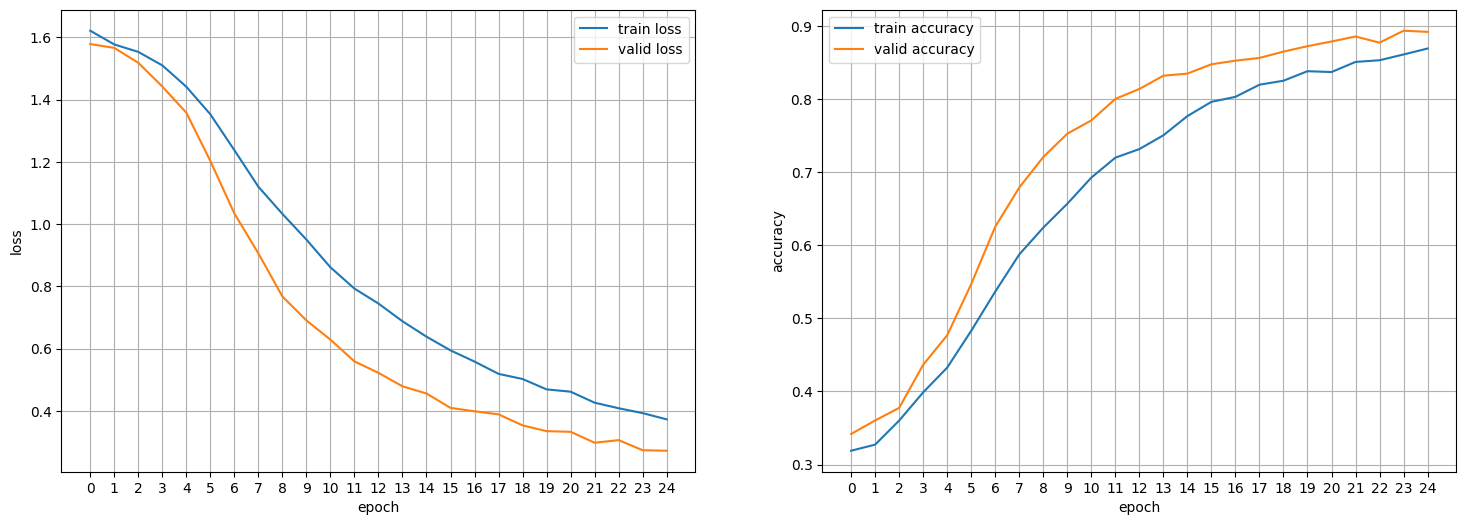

In [69]:
#plot train and validation loss and accuracy
plot_metrics(metrics, n_epochs)

In [70]:
# Test evaluation
test_loss, test_acc = evaluate(test_data_loader, my_model, criterion, device)
print("\ntest_loss", test_loss)
print("test_accuracy", test_acc)


evaluating...: 100%|██████████| 4/4 [00:00<00:00, 30.14it/s]


test_loss 0.2735031209886074
test_accuracy 0.8985890299081802


In [71]:
# Classification report
with torch.no_grad():
    all_preds, all_labels = [], []
    for batch in tqdm.tqdm(test_data_loader, desc="evaluating..."):
        ids = batch["input_ids"].to(device)
        att = batch["attention_mask"].to(device)
        label = batch["label"].to(device)
        prediction = my_model(ids, att)
        all_preds.append(prediction)
        all_labels.append(label)
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    print_classification_summary(all_preds, all_labels, classes)

evaluating...: 100%|██████████| 4/4 [00:00<00:00, 44.21it/s]


Classification Summary:

              precision    recall  f1-score   support

     sadness      0.944     0.933     0.939       581
         joy      0.918     0.921     0.920       695
        love      0.746     0.849     0.794       159
       anger      0.920     0.876     0.898       275
        fear      0.883     0.844     0.863       224
    surprise      0.708     0.773     0.739        66

    accuracy                          0.899      2000
   macro avg      0.853     0.866     0.859      2000
weighted avg      0.901     0.899     0.900      2000



In [72]:
# Example predictions
example_texts = [
    "iam happy to meet you",
    "i love you",
    "iam very upset iam sick",
    "i cant stand delaying my PhD defense any more",
    "i can punhs them in the face right now",
    "the hardest part about growing up is saying goodby to childhood dreams",
    "how did you do that to me?",
    "how dare you stand where he stod?"
]
for text in example_texts:
    sentiment, prob = predict_sentiment(text, my_model, autotokenizer, device, embedding_dim, classes)
    print(f"Text: {text}\nPredicted: {sentiment} ({prob:.3f})\n")

Text: iam happy to meet you
Predicted: joy (0.765)

Text: i love you
Predicted: love (0.299)

Text: iam very upset iam sick
Predicted: sadness (0.484)

Text: i cant stand delaying my PhD defense any more
Predicted: joy (0.609)

Text: i can punhs them in the face right now
Predicted: joy (0.500)

Text: the hardest part about growing up is saying goodby to childhood dreams
Predicted: joy (0.576)

Text: how did you do that to me?
Predicted: joy (0.254)

Text: how dare you stand where he stod?
Predicted: joy (0.266)



In [73]:
#save the model using pckl file
import pickle
id = datetime.datetime.now().strftime("%d_%b_%Y_%H_%M_%S")
with open('./models/RNN_model_sentiment_'+id+'.pkl', 'wb') as f:
    pickle.dump(my_model, f)

In [74]:
def gradio_predict(text):
      sentiment, prob = predict_sentiment(
          text, my_model, autotokenizer, device, embedding_dim, classes
      )
      return f"{sentiment} ({prob:.2f} confidence)"

# Launch Gradio interface
demo = gr.Interface(
    fn=gradio_predict,
    inputs=gr.Textbox(lines=3, placeholder="Enter a sentence..."),
    outputs=gr.Textbox(label="Predicted Sentiment"),
    title="Sentiment Analysis with NBoW",
    description="Enter a sentence to analyze its sentiment using a custom neural bag-of-words model.",
    examples=[ example_texts[i] for i in range(len(example_texts)) ]
)

demo.launch()

* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.
